# One-sample t-test

In [2]:
# Import data analysis and visualization packages.
import arviz as az
from cmdstanpy import CmdStanModel, write_stan_json
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import scipy.stats as stats
import seaborn as sns

#Specify the number of chains to the number of availible cpu's.
n_chains = os.cpu_count()
n_samples = 1000
# Convert to int so Stan will not crash below.
n_warmup = int(n_samples/2)
#Specify step size.
stepS = .8

In [3]:
from IPython.core.display import HTML as Center

Center(""" <style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style> """)

# Bayesian estimation equivalent of the one-sample t-test

This notebook follows nicely on from the Bayesian equivalent of the classical Z-test and provides an example equivalent of a Bayesian one sample t-test. However, the analyis below is conducted on a real dataset and demonstrates for a simple case the realities of fully probabalistic statistical modelling and dealing with uncertainty under the Bayesian framework.


## The classic one sample t-test

Before going any further, a brief review of the one sample t-test is given. The one-sample t-test calculates a t-statistic from calculating the difference between the sample mean and theorised known null hypothesis population mean and then finding the quotient of this difference over the estimated standard error from the sample data.


$$ \large t = \frac{\bar{X}-\mu_0}{\frac{S}{\sqrt{N}}}$$ 

where

$\mu_0 = $ is a theorised constant for the population mean

$\bar{X} = $ sample mean

$N = $ Sample size

$S = $ sample standard deviation

$\frac{S}{\sqrt{N}} = $ estimated standard error


This t statistic is then used to calulate a p-value under a null sampling distribution with a certain degrees of freedom which is determiend by the smaple size ($df = n - 1$). If this p-value is $\leq$ to the 𝛼 level pre-determined before the analysis under the Null hypothesis significance test the resuts is determined to be statistically signicant and the null hypothesis is rejected.

$$ \large H_0:\bar{X} = \mu_0$$
$$ \large H_1:\bar{X}\neq \mu_0$$

# Bayesian inference
<font size = "3"> Following on from that quick description of the classic one sample t-test above its important to keep in mind that Bayesian inference is all derived from the application of Bayes rule 
$$P(\theta \mid y) = \frac{P(y \mid \theta) \, P(\theta)}{P(y)}$$

and as such while the following description of the Bayesian model is an equivalent to the one sample t-test, it is fundamentally different, because it uses fully probabilistic modelling and the inference is not based on sampling distributions.</font>
    
<font size = "1"> For a fuller description see the Practicing Bayesian statistics markdown file within the Github repository.</font>

# Steps of Bayesian data analysis

<font size = "3"> Kruscke (2015) offers a step by step formulation for how to conduct a Bayesian analysis:

1. Identify the relevant data for the question under investigation.

2. Define the descriptive (mathematical) model for the data.

3. Specify the Priors for the model. If scientific research publication is the goal the priors will need to be accepted by a skeptical audience. This should be achievable using prior predictive checks to ascertain if the priors are reasonable.

4. Using Bayes rule estimate the posterior for the parameters of the model using the likelihood and priors. Then use the posterior for conducting your inferences.

5. Conduct model checks. i.e. Posterior predcitive checks.</font> 

<font size = "1">This notebook will follow this approach generally.</font> 

#  Step 1 - Identify the relevant data for the question under investigation

## Study/data description

The data analysed here were produced and analysed originally by Mehr, S. A., Song. L. A., & Spelke, E. S. (2016). For 5-month-old infants, melodies are social. Psychological Science, 27, 486-501. The data analysed below were downloaded from https://sites.google.com/view/openstatslab/home and stored in the same Github repository where these notebooks are stored.

The research focused on the seemingly universal act of parents singing to their children and that this singing appears to focus their childs attention towards the parent that is singing. Mehr et al. (2016), aim was to study the function of this singing between mother and child. in particular Mehr et al. hypothesised that these specific melodies convey social information to infants.

The resarchers argued that social groups share melodies and that different melodies exist between social groups. These shared melodies might signal to infants that novel individuals who sing these songs are from the same social group. Therefore, if a novel person sings a familiar melody this may signal to the infant group membership of this novel individual.

All together, 32 parent and infant pairs were recuited with the aim of testing the hypothesis that melodies signal group membership to infants. The methodology they used to test this hypothesis involved taking each infant and mother pair in and  teaching them a new lullaby during theit first visit to the lab. The parents were then asked to sing the new lullaby to the infant every day for a 1-2 weeks before the return to the lab for the experimental session. 

The Experimental session consisted of showing the infants side by side videos of two unfamilliar individuals, on seperate screens. As with many infant studies the infant gaze is the standard behavioural measure for assessing infants attention. During the initial period of the experiment the two unfamiliar faces were presented with them both smiling at the infant silently. This allowed expert raters to produce baseline gaze proportions. This was followed by the each of the unique indivduals singing their lullaby (either the one the mother had been taught or one that had the sme rhythm, and lyrics but the melody was different). Folwwing this singing of the luublabies the infants were then left to view the two individuals when silent and smiling, to record another gaze proportion score.

Of particular concern for this notebook is the Baseline proprtion scores, which were analysed in the orignal study using a one sample t-test with its goal to test if there was any bias in the infants basline gaze proportions as a group by comparing  the $\bar{x}$ with a hypothsied proportion of $\mu = .5$, to test for any statistical differnce. Mehr et al. did noto find a statistically significant differecne at the $\alpha \leq .05$ and proceeded to claim that this showed tere was no bias in baseline proprotion for either of the indivudals presented on the two screens. There are statistical reasoning faults of this approach due to the limits of the NHST that will not be discussed further here. However, for the interested parties Dienes (2014) explains the problem nicely and how Bayesian methods can offer a solution, and it will not be discussed further here, because the methods below offer a Bayesian estimation solution to the problem of determining any bias is baseline gaze probabilistically in the fashion of a Bayesian estiamtion equivalent of the one sample t-test.

## Import data

In [4]:
# Call github repository were the data is stored
url = "https://raw.githubusercontent.com/ebrlab/Statistical-methods-for-research-workers-bayes-for-psychologists-and-neuroscientists/master/wip/Data/Mehr%20Song%20and%20Spelke%202016%20Experiment%201.csv"

# Import data .csv file into a pandas dataframe
df = pd.read_csv(url)

In [5]:
# Output data frame for evaluation
df.head(1)

,id,study_code,exp1,exp2,exp3,exp4,exp5,dob,dot1,dot2,...,dtword13,dtnoword13,totsing14,babylike14,singcomf14,totrecord14,othersong14,dtword14,dtnoword14,filter_$
0,101,"""LUL""",1,0,0,,,09-Oct-12,29-Mar-13,05-Apr-13,...,0,0,,,,,,0,0,1


### Clean the data

The analysis below is conducted on the experiment 1 data of Mehr et al. (2016), as such the data needs to be cleaned and reduced for clarity before condcuting any analyses.

In [6]:
# The data for the specific experiment is in the first 32 rows of the dataframe
red_df = df.iloc[0:32,]

# unmark code below to output dataset for any checks that see fit (i.e. that extracting only experiment one)
red_df.tail(5);

### Data visualisation and exploratory data analysis 

/tmp/ipykernel_108056/2658784654.py:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(red_df["Baseline_Proportion_Gaze_to_Singer"], fit = stats.norm, kde= False);


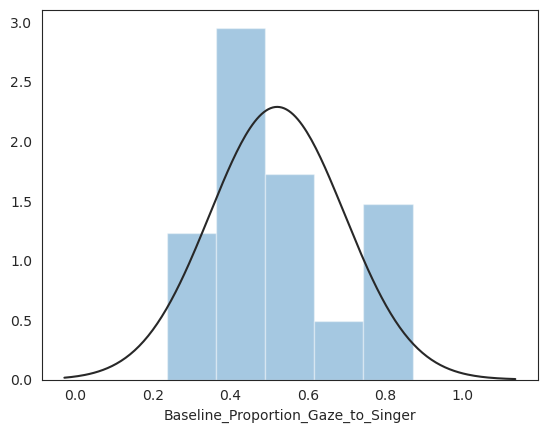

In [7]:
# Set Seaborn theme for data visualisations.
sns.set_style("white");

# PLotting a histogram and Kernel density estimate of the baseline gaze proportion scores
sns.distplot(red_df["Baseline_Proportion_Gaze_to_Singer"], fit = stats.norm, kde= False);

Just Eyeballing the data visualistaiton above might suggest that the data is not normally distributed. However, there are only 32 data points, so we have a high level of uncertainty around determining this. As such the use of a normal likelihood may still be appropriate and as the intial authors used a one sample t-test, which assumes normal distributed data, the analysis below will assume a normal likelihood for the Bayesain equivalent of the one-sample t-test.

# Step 2 - Define the descriptive statistical model 

\begin{align*}
y_i &\sim Normal(\mu, \sigma) 
\\ \mu &\sim Normal(0.5, 0.2) 
\\ \sigma &\sim Exponential(0.1) 
\end{align*} 

<font size = "3">The formulation for presenting statistical models here follows that used by McElreath (2020) for its intuitive nature. In plain english the model specifies that the dependent variable $y_i$ is distributed normally in terms of the Likelihood. The $\mu$ and $\sigma$ parameters are to be estimated. With the priors for the $\mu$ parameter being $Normal(0.5, 0.2)$ and the $\sigma$ being expoentially distributed $Exponential(0.01)$


# Step 3 - Specifying priors

Following the description of the statistical model above the readers should rightly review and criticise the model freely, especialliy in asking why i selected these priors. The priors were selected using the prior predictive checks i ran in the code below to determine if my priors can generate data that falls reasonable on the dependent variable outcome space for the data generating process i am trying to model which in this case is expert rating of baseline gaze proportion scores of infants.

## Prior predictive checks

### Visualising priors

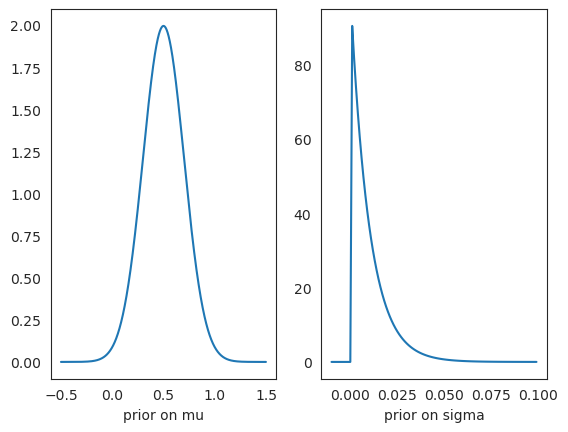

In [8]:
# Visualise prior on mean parameter.
x = np.arange(-0.5, 1.5, 0.001)

plt.subplot(1, 2, 1)
plt.plot(x, stats.norm.pdf(x,loc=0.5, scale=0.2));
plt.xlabel("prior on mu");

# Visualise prior on Standard deviation parameter.
x = np.arange(-.01, .1, 0.001)
plt.subplot(1, 2, 2)
plt.plot(x, stats.expon.pdf(x, scale = 0.01));
plt.xlabel("prior on sigma");

### Simulating data based on priors

Following the visualisation of the priors for the parameters of the model to 
check how they interact it is important to run prior predcitive check by 
simulating data based on the model.

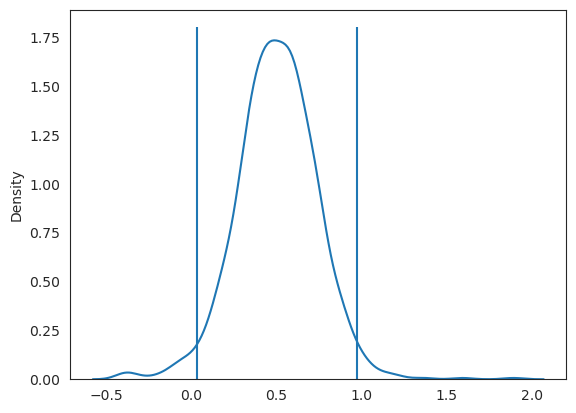

In [13]:
# Set seed to allow for the reproduciblity of notebook.
np.random.seed(1)

# Set the number of data point to sample
n = 1000
#Specify prior values for mu
mu_loc = 0.5
mu_scale =.2

#Specify prior values for sigma
sd_scale = .1


# Simulate data from the priors for the mean and SD for the normal model specified above.
sample_mu = np.random.normal(loc= mu_loc, scale = mu_scale, size = n )
sample_sigma = np.random.exponential(scale = sd_scale, size = n )
prior_PC = np.random.normal(loc = sample_mu, scale = sample_sigma, size = n)

# Plot the simulated data
sns.kdeplot(prior_PC);

# Plot vertical line of the 2 standard deviatons either side of the simulated data.
plt.vlines((np.mean(prior_PC) + 2 * np.std(prior_PC)), ymin = 0, ymax = 1.8);
plt.vlines((np.mean(prior_PC) - 2 * np.std(prior_PC)), ymin = 0, ymax = 1.8);

The prior predictive check show that generate reasonable data for baseline child gaze rated by expert rates on a proprotion scale between 0 and 1 follwing a normal model. Rember it doesnt matter if it looks like the data this is all in reltion to prior so everything is done in terms of assumptions of the unobserved data generating process (which in this case we assume is can be described by a normal pdf) not the data we actually observed.

# Step 4 - Use Bayes rule
The software of choice to conduct Bayesian inference on the data here is Stan (Carpenter et al., 2017) and the model is specified below.

## Stan model of Bayesian One sample t-test

In [12]:
# Stan model to replciate the frequentist one sample t-test.

One_sample_t_test_model = """

data{

int<lower = 1> N;
vector[N] y;

}

parameters{

// Model paramaters to be estimated

 real<lower=0, upper=1> mu;// Bounded between 0 and 1 because as proportion of gaze scores cannot exceed those bounds
 real<lower=0> sigma; //Standard deviation bounded at 0
 
}

model{

//priors
// Informed prior based on the use of a normal likelihood to estimate mean and standard deviation parameters
// of proportion score that ranges from 0 to 1

mu ~ normal(0.5, 0.2);
sigma ~ exponential(0.1);

// Likliehood
y ~ normal(mu, sigma);

}

generated quantities {

//Generated a real value for difference between the MCMC sample of mu and 0.5.
real diff = mu - 0.5;

// Generating a quantity of a effect size similar to cohen D of a standarised diffence comparing
// a reference mean (here is proportion of 0.5) as would be specified in a one sample t-test
real Cohen_D = diff / sigma; 
  
vector[N] yrep;
  
// Generate data for posterior samples
  for (i in 1:N) {
    yrep[i] = normal_rng(mu, sigma);
 }
}
"""

In [13]:
# Generate python dictionary to pass to Stan model to sample and run Bayesian One sample.
data = {'N': len(red_df),
        'y':  red_df["Baseline_Proportion_Gaze_to_Singer"].values}

In [14]:
# StanModel function can be called and be passed the model string specified above to compile into C++ code.
sm  = ps.build(One_sample_t_test_model, data = data)

Building...



Building: 36.1s, done.

In [15]:
# Fit and sample posterior for the model for the data, taking 2000 samples per 4 chains.
fit = sm.sample(num_chains = n_chains , num_samples = n_samples, num_warmup = n_warmup, stepsize = stepS)

Sampling:   0%
Sampling:  25% (3000/12000)
Sampling:  50% (6000/12000)
Sampling:  75% (9000/12000)
Sampling: 100% (12000/12000)
Sampling: 100% (12000/12000), done.
Messages received during sampling:
  Gradient evaluation took 4e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.4 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 3.9e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.39 seconds.
  Adjust your expectations accordingly!
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/tmp/httpstan_hqvj9g1d/model_kcfbbnic.stan', line 29, column 0 to column 22)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either sever

In [16]:
# Using arviz generate summary table for parameters and generated quantities.
az.summary(fit, var_names = ['mu', 'sigma', 'diff', 'Cohen_D'])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu,0.520,0.033,0.455,0.579,0.000,0.000,5841.0,4940.0,1.0
sigma,0.184,0.025,0.141,0.231,0.000,0.000,5123.0,4871.0,1.0
diff,0.020,0.033,-0.045,0.079,0.000,0.000,5841.0,4940.0,1.0
Cohen_D,0.111,0.176,-0.233,0.428,0.002,0.002,6164.0,5047.0,1.0


# Post model fit-visualisations - Bayesian one sample Z-test

## Posterior distributions plots

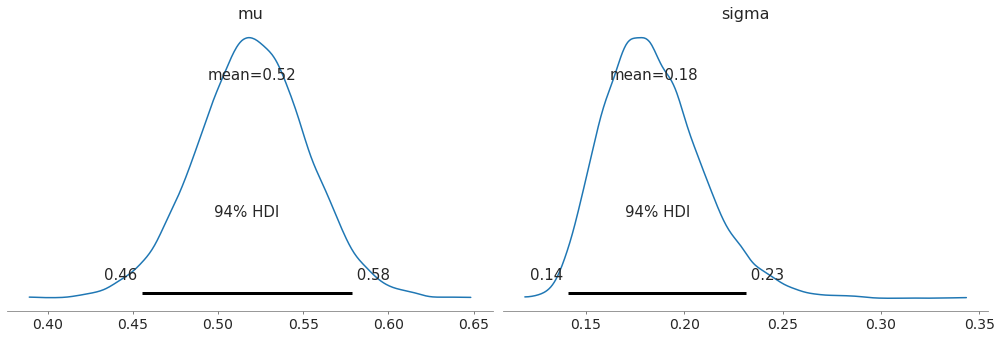

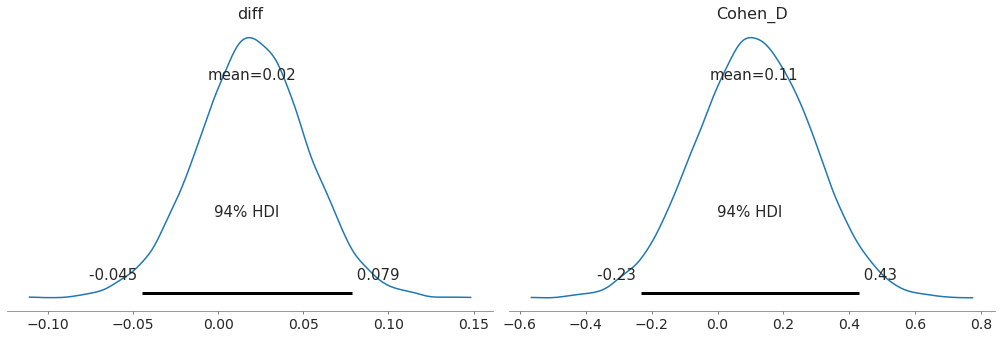

In [17]:
# Using arviz built in Bayesian anlysis plot_posterior funcion to display the posterior probabilty distributions
# for the fitted model parameter estimates.
az.plot_posterior(fit, var_names = ["mu", "sigma"]);
az.plot_posterior(fit, var_names = ["diff", "Cohen_D"]);

## Autocorrelation plots

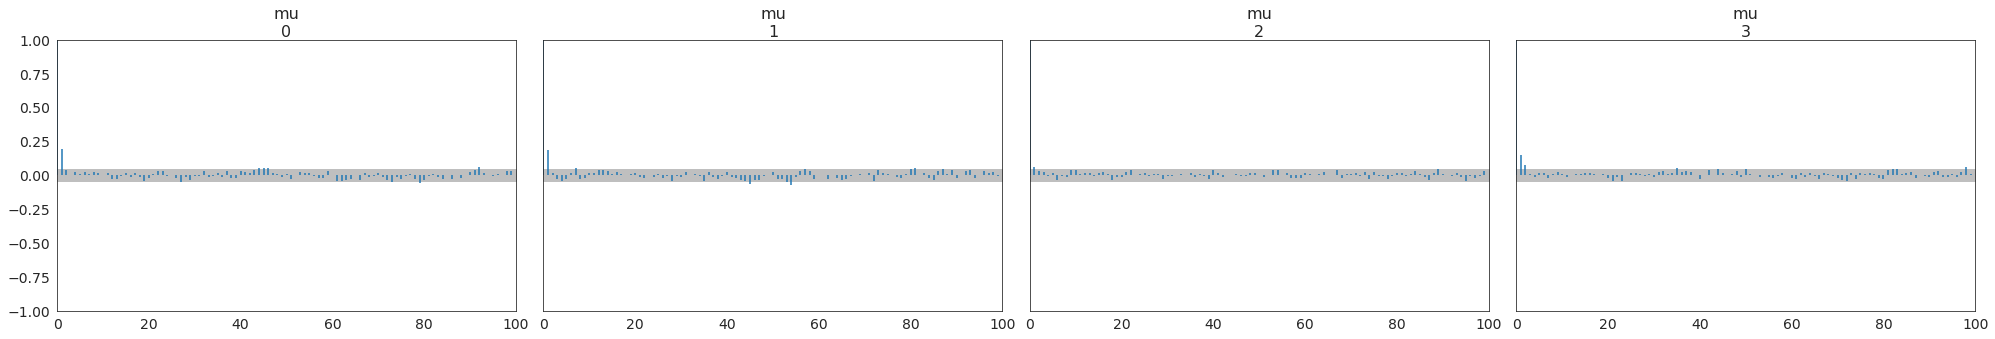

In [18]:
# Using the arviz package the autocorrelation of the 4 MCMC chains can be plotted.
az.plot_autocorr(fit, var_names = ["mu"]);

The autocorrelation plots do not show any serious autocorrelation problems, as the values quickly decrease to 0.

## MCMC traceplots

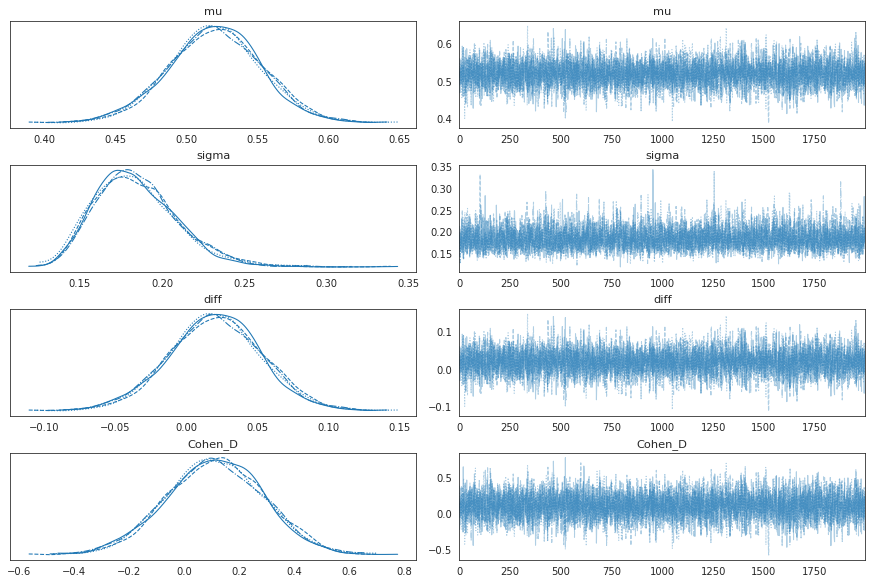

In [19]:
az.plot_trace(fit,var_names=("mu", "sigma", "diff", "Cohen_D"));

The traceplot show good mixing of chains and show a hairy catepillar.

# Step 5 - Posterior predictive checks

In [20]:
yrep_df  = pd.DataFrame(fit['yrep']).T.iloc[:,:]

In [21]:
idata = az.from_pystan(posterior = fit, posterior_model = sm, posterior_predictive = ['yrep'], observed_data= 'y')                

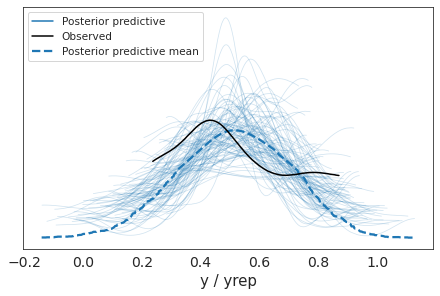

In [22]:
# Plot posterior simulated data sets for posterior predictive check
az.plot_ppc(idata, data_pairs = {"y" : "yrep"}, num_pp_samples = 100);

The posterior predictive check shows that the simulated data sets condtioning the model on the data vary from  the original data sets. This could mean many things; the first being that an alternative better fitting model may need to be fit or   secondly that the small amount of data from a highly variable measure of infant gaze which has to go through a noisy expert rater) is presenting a simple reality that our model and its resulting inferences are more uncertain. Of course, this is not neccesarily a problem it just needs to be communicated to and appreciated by the audience that is viewing the results of the analysis, whom may even recommend improvements for the model and the modellers choices.

# Reporting the results of the Bayesian one sample t-test equivalent

<font size = "3">As Kruscke correctly points out there is not standard formula or presentation method for results like the APA guide for reporting frequentist analyses using the Bayesian framework. It is likely there never will be, because as McElreath (2020) explains, Bayesian data analysis is more like a engineering approach to the problem and the resulting model that is fit will be analysis specific. In addition, as Gabry et al, (2019) have argued visualisations maybe even more key, so all the visualtions above would have to be included with any write up. Anyway, the write up below generally follows the advice of Kruscke (2015) chapter 25. In any application though it comes down to the problem to be described and the audience that needs to be convinced. </p><br/>

<h2>Write up</h2><br/>

# References

Carpenter, B., Gelman, A., Hoffman, M. D., Lee, D., Goodrich, B., Betancourt, M., ... & Riddell, A. (2017). Stan: a probabilistic programming language. Grantee Submission, 76(1), 1-32.

Dienes, Z. (2014). Using Bayes to get the most out of non-significant results. Frontiers in psychology, 5, 781.

Gabry, J., Simpson, D., Vehtari, A., Betancourt, M., & Gelman, A. (2019). Visualization in Bayesian workflow. Journal of the Royal Statistical Society: Series A (Statistics in Society), 182(2), 389-402.
    
Kruschke, J. (2015). Doing Bayesian data analysis: A tutorial with R, JAGS and Stan. Oxford, England: Academic Press.    
    
McElreath, R. (2020). Statistical rethinking: A Bayesian course with examples in R and Stan.Boca Raton: CRC Press.

Mehr, S. A., Song. L. A., & Spelke, E. S. (2016). For 5-month-old infants, melodies are social. Psychological Science, 27, 486-501.